In [1]:
import numpy as np
from matplotlib import pyplot as plt

def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return np.array(x_sample), np.array(y_sample)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(1000, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(1000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [ ]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math


def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(model.n_classes_*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - (model.n_classes_ - 1)/(model.n_classes_*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 200, .32)

def get_mutual_information(X, y, n_estimators = 300, max_samples = .32, depth = 30):
    cond_entropy = rf_entropy_estimate_bagging(X, y, n_estimators = n_estimators, max_samples = max_samples, depth = depth)
    h_y = get_entropy(y)
    return h_y - cond_entropy


In [20]:
from tqdm import tqdm_notebook
import sys
sys.path.insert(0, "./code")
import entropy_estimators as ee
import mixed

def mutual_information_v_n(mu, d):
    sample_sizes = [i*50 for i in range(1, 51)]

    cef = []
    kraskov = []
    mixed_ksg = []
    for n in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(n, d, mu)
        h_y = get_entropy(y)
        kraskov.append(ee.micd(X, y.reshape(-1, 1)))
        cef.append(get_mutual_information(X, y)/h_y)
        mixed_ksg.append(mixed.Mixed_KSG(X, y.reshape(-1, 1))/h_y)
    return sample_sizes, cef, kraskov, mixed_ksg

In [11]:
sample_sizes, cef, kraskov, mixed_ksg = mutual_information_v_n(1, 6)

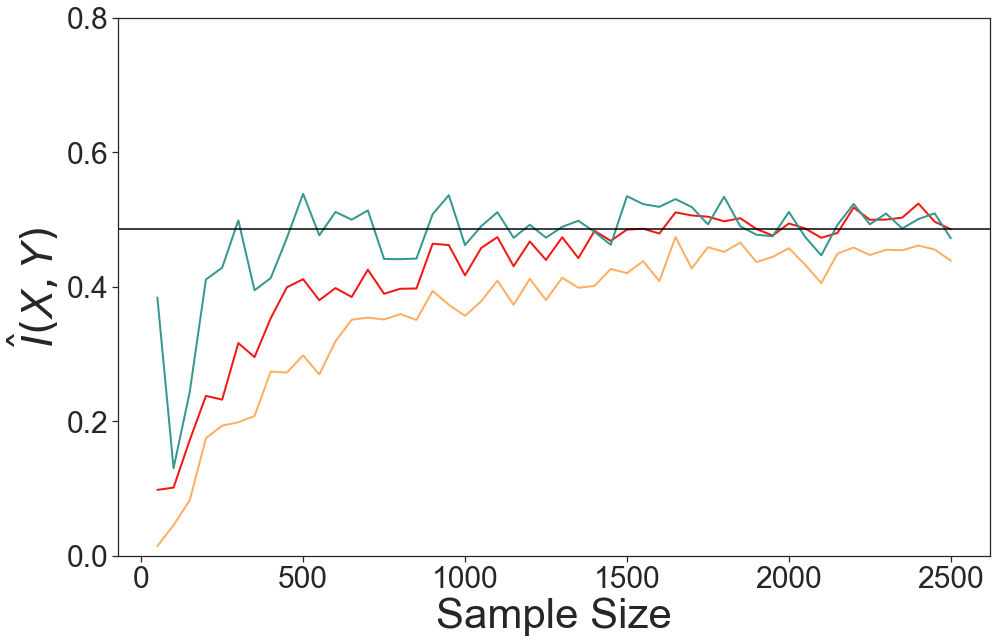

In [27]:
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, kraskov, label = "KSG", linewidth = 2, color = "#35978f")
plt.plot(sample_sizes, mixed_ksg, label = "Mixed KSG", linewidth = 2, color = "#fdae61")


line_true = plt.axhline(y=.486,linestyle='-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Normalized MI")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
#plt.legend()
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("mi_convergence_d_6_mu_1.pdf")
plt.show()

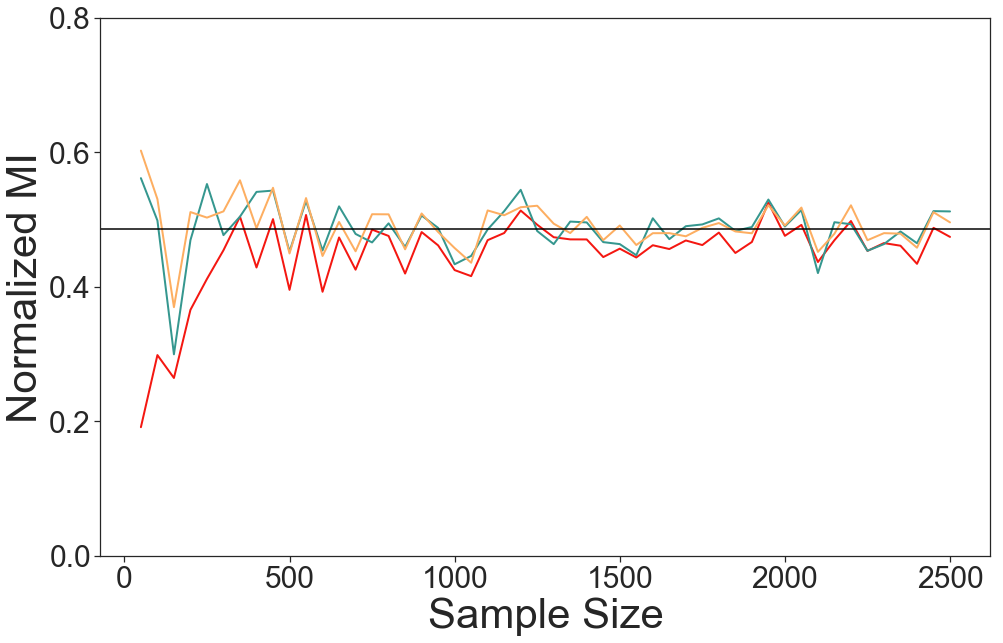

In [31]:
sample_sizes, cef, kraskov, mixed_ksg = mutual_information_v_n(1, 1)
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, kraskov, label = "KSG", linewidth = 2, color = "#35978f")
plt.plot(sample_sizes, mixed_ksg, label = "Mixed KSG", linewidth = 2, color = "#fdae61")


line_true = plt.axhline(y=.486,linestyle='-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Normalized MI")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
#plt.legend()
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("mi_convergence_d_1_mu_1.pdf")
plt.show()

In [5]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import math
from sklearn import mixture

def estimate_p(y):
    return y.count(1)/len(y)

def estimate_x_params(X):
    model = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
    model.fit(X)
    return model.means_, model.covariances_
    
estimate_x_params(X)

def normal_entropy_f(t, mean, var):
    return -norm.pdf(t, mean, var)*np.log(norm.pdf(t, mean, var))

def two_mixture_normals_entropy_f(t, mean_1, mean_2, var_1, var_2):
    return -.5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2)) - .5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2))

def normal_entropy(var):
    return .5*np.log(2*math.pi*math.e*var)

#NOTE: this doesn't work for mean = 0
def plugin_estimate_cat_1D(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    #h_x_cond_y = integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][0], x_params[1][0].item()))[0]*.5 + \
    #integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][1], x_params[1][1].item()))[0]*.5
    h_x_cond_y = normal_entropy(x_params[1][0])*.5 + normal_entropy(x_params[1][1])*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (x_params[0][0], x_params[0][1], x_params[1][0].item(), x_params[1][1].item()))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy

def truth_1d(mean):
    h_y = -.5*np.log(.5) - .5*np.log(.5)
    h_x_cond_y = normal_entropy(1)*.5 + normal_entropy(1)*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (mean, -mean, 1, 1))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy


def mutual_information_truth():
    entropy = -.5*np.log(.5) - .5*np.log(.5)
    means = [1]
    truths = []
    for elem in means:
        truths.append(entropy - truth_1d(elem))
    #return means, cef_all, plugin_all, truth
    return truths

In [19]:
truth = mutual_information_truth()

In [20]:
truth

[0.3368308203468321]

In [21]:
.33683082/(-.5*np.log(.5) - .5*np.log(.5))

0.48594415363256305

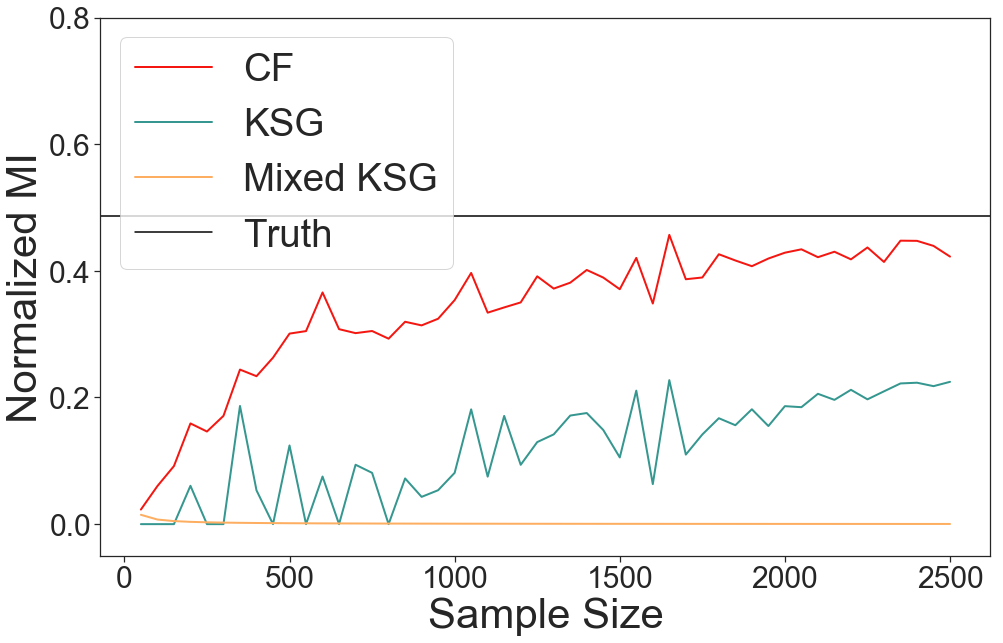

In [22]:
import seaborn as sns
#sample_sizes, cef, kraskov, mixed_ksg = mutual_information_v_n(1, 20)
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, kraskov, label = "KSG", linewidth = 2, color = "#35978f")
plt.plot(sample_sizes, mixed_ksg, label = "Mixed KSG", linewidth = 2, color = "#fdae61")


line_true = plt.axhline(y=.486,linestyle='-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Normalized MI")
plt.ylim(ymin = -.05)
plt.ylim(ymax = .8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.legend()
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("mi_convergence_d_20_mu_1.pdf")
plt.show()

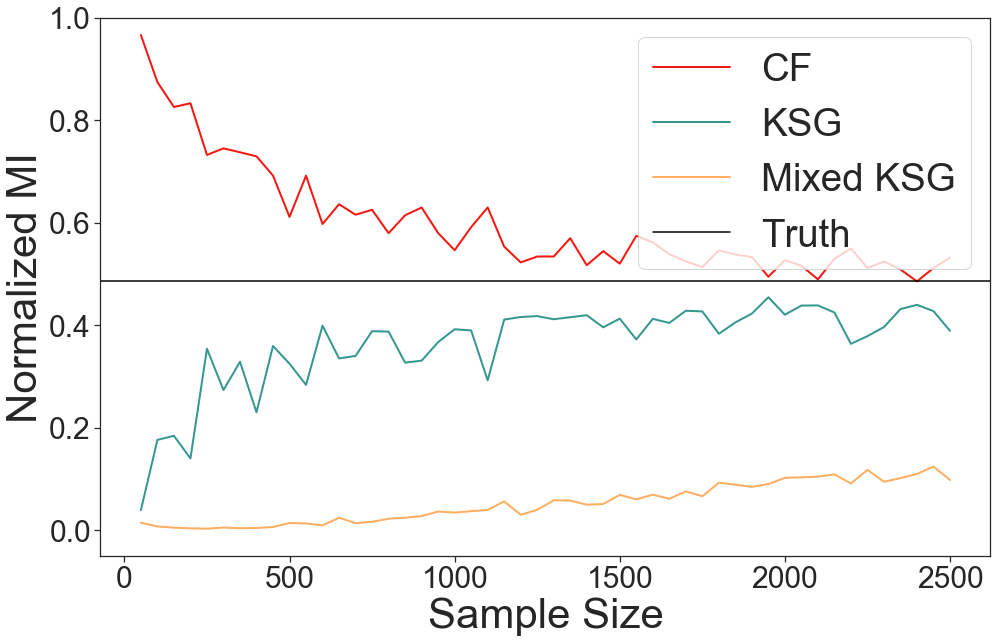

In [17]:
import seaborn as sns
#sample_sizes, cef, kraskov, mixed_ksg = mutual_information_v_n(1, 10)
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, kraskov, label = "KSG", linewidth = 2, color = "#35978f")
plt.plot(sample_sizes, mixed_ksg, label = "Mixed KSG", linewidth = 2, color = "#fdae61")


line_true = plt.axhline(y=.486,linestyle='-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Normalized MI")
plt.ylim(ymin = -.05)
plt.ylim(ymax = 1)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.legend()
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("mi_convergence_d_10_mu_1.pdf")
plt.show()